In [1]:
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Estimator
import numpy as np
import matplotlib.pyplot as plt
import cspsa
from qiskit.quantum_info import Statevector, random_clifford
from scipy.optimize import minimize

In [2]:
from FastFidelity import Mean_Direct_Fidelity

### Initial Parameters

In [12]:
NQs = [2,3,4,5]
L = len(NQs)
N = 10
shots = 10_000
simulator_ideal=Estimator(backend_options={'shots':shots,},
                            transpile_options={'optimization_level':0},
                            ) 
n_jobs = -1

In [13]:
def min( phi, MDF ):
    phi = phi / np.linalg.norm(phi)
    phi = np.array( [ phi.real, phi.imag ] )
    
    def CostF( psi, MDF ): 
        psi = psi.reshape(2,-1)
        psi = psi[0] + 1j*psi[1]
        M_d = MDF.Measures 
        M   = MDF.Chi(psi,truncation=False) 
        f   = 0
        for j, _ in enumerate( M ):
            if j in M_d:
                f += np.sum( np.abs( M_d[j] - M[j] )**2 ) 
            else:
                f += 0.1*np.sum( np.abs( M[j] ) )**2 
        return f 

    results = minimize( CostF, phi, args=(MDF) )
    psi_hat = results.x / np.linalg.norm(results.x )
    psi_hat = psi_hat.reshape(2,-1)
    psi_hat = psi_hat[0] + 1j*psi_hat[1]
    return psi_hat

In [14]:
from joblib import Parallel, delayed

def simulate( NQ, simulator ):
    MDF = Mean_Direct_Fidelity(NQ)
    Fidelities = []
    Measures = []
    Last=[]
    d=2**NQ
    
    # Omega = QuantumCircuit(NQ)
    # Omega.h(0)
    # for a in range(NQ-1):
    #     Omega.cx(a, a+1)

    Omega = random_clifford( NQ ).to_circuit()

    OmegaM=np.outer(np.array(Statevector(Omega)),
                    (np.array(Statevector(Omega))).conj()) 

    f=lambda x: 1 - np.vdot(x, OmegaM@x)/(np.linalg.norm( x ))**2

    psi0 = np.random.rand(d) + 1j * np.random.rand(d)
    # psi0 = np.ones(d)
    # psi0 = np.zeros(d)
    # psi0[[0,-1]] = 1 
    psi0 = psi0 / np.linalg.norm(psi0)
    guess = psi0
    def callback0( i, x ):
        Last.append(x)
        Fidelities.append(f(x))
        Measures.append(len(MDF.Measures))
        return None

    I = lambda x:  1 - MDF.MeanFidelity(1, 2*NQ, x/np.linalg.norm(x), Omega,
                                    estimator=simulator, shots=10000, 
                                    truncation=False) 

    # I = f
    
    GAINS = {
            "a": 3.0,
            "b": 0.1,
            "A": .0,
            "s": 1.0,
            "t": 1 / 6,
            }

    def update(guess,update):
        guess = guess + update
        guess = guess / np.linalg.norm( guess )
        # print( '0', guess )
        guess = min( guess, MDF ) 
        # print( '1', guess )
        return guess

    optimizer = cspsa.CSPSA( init_iter=0, 
                            callback=callback0,
                            gains = GAINS,
                            apply_update = update,
                            perturbations=(1,-1,1j,-1j,)
                            )
    
    num_iter = 10

    optimizer.run(I, guess, progressbar=False, num_iter=num_iter)
    Results=[np.array(Fidelities),
                        np.array(Measures),
                        np.array(Last)
                        ]

    return Results  #j index the average over the Hilbert space


In [15]:
# results = simulate( 5, 0, simulator_ideal )

In [16]:
from itertools import chain
R = []
# Iterar sobre cada valor en NQs
for NQ in NQs:
    Data0 = Parallel(n_jobs=n_jobs, verbose=11)(
        delayed(simulate)(NQ, simulator_ideal) for _ in range(N))    
    R.append(Data0)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    4.0s remaining:   16.2s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    4.0s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    4.2s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.4s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.5s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.6s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    4.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Pa

In [17]:
Fids = []
Meas = []

for l, NQ in enumerate(NQs):
    Fids_n = []
    Meas_n = []
    for n in range(N):
        Fids_n.append( R[l][n][0] )
        Meas_n.append( R[l][n][1] )
    Fids.append( Fids_n )
    Meas.append( Meas_n )

Fids = np.median( Fids, axis=1 )
Meas = np.median( Meas, axis=1 )

c:\Users\lucia\miniconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


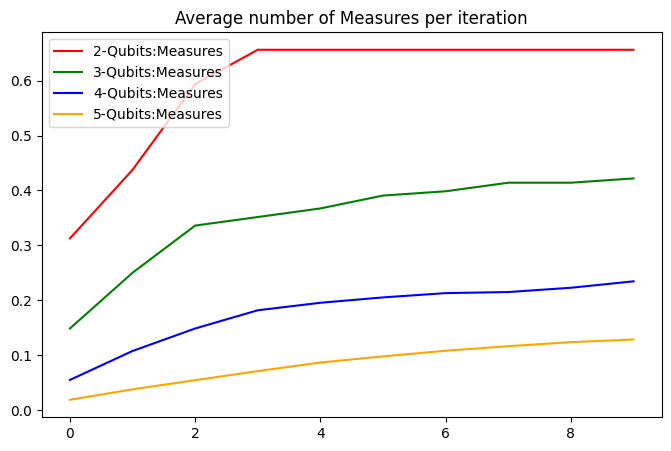

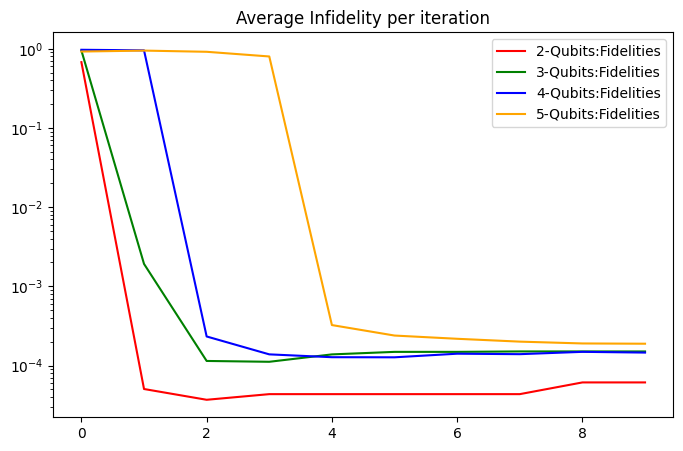

In [22]:

import matplotlib.pyplot as plt

# Lista de colores arbitrarios
colores = ['r', 'g', 'b', 'orange', 'purple']

# Crear primer conjunto de gráficos para Measures
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_title('Average number of Measures per iteration')

for j in range(len(NQs)):
    ax1.plot(Meas[j]/4**NQs[j], label=f'{NQs[j]}-Qubits:Measures', 
                linestyle='-', color=colores[j])
    # ax1.axhline( 4**NQs[j], color=colores[j], linestyle='--' )
ax1.legend()
# Guardar el primer conjunto de gráficos
fig1.savefig('Measures.png')

# Crear segundo conjunto de gráficos para Measures
fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.set_title('Average Infidelity per iteration')

for j in range(len(NQs)):
    ax2.semilogy( Fids[j], label=f'{NQs[j]}-Qubits:Fidelities', 
                    linestyle='-', color=colores[j])

ax2.legend()
# Guardar el segundo conjunto de gráficos
fig2.savefig('Fidelities.png')
    